# Начнем с парсинга xml-данных

In [2]:
import xml.etree.ElementTree as ET
import numpy as np
import os
import random

dataset = []

def traverse(folder, is_text, data):
    for path in os.listdir(folder): 
        if ".xml" in path:
            parsed_xml = ET.parse(os.path.join(folder, path)).getroot().findall("Image/WordFragment")
            for wfrag in parsed_xml:
                values = wfrag.attrib
                values['IsText'] = is_text
                rect = wfrag.find("Rect").attrib #нормируем признаки по размеру области
                size = (float(rect['Right']) - float(rect['Left'])) * (float(rect['Bottom']) - float(rect['Top']))
                black_count = float(values['BlackCount'])/size
                white_holes_count = float(values['WhiteHolesCount'])/size
                horz_strokes_count = float(values['HorzStrokesCount'])/size
                vert_strokes_count = float(values['VertStrokesCount'])/size
                max_horz_strokes_count = float(values['MaxHorzStrokeLength'])/size
                data.append([black_count, 
                            white_holes_count,
                            horz_strokes_count,
                            vert_strokes_count,
                            max_horz_strokes_count,
                            1.0, #это будет сдвиг
                            values['IsText']])

traverse("./text", 1, dataset)
traverse("./nontext", -1, dataset)

print(len(dataset))

43009


In [3]:
random.seed(1e9+7)
random.shuffle(dataset)
dataset = np.array(dataset)

X = dataset[:,:6]
Y = dataset[:,6].astype(int)
text = 0
nontext = 0
for i in range(len(Y)):
    if (Y[i] == 1):
        text += 1
    else:
        nontext += 1
print(text, nontext)

24935 18074



# Классы распределены более-менее равномерно.
# Разобъем данные на обучающую и тестовую выборку


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(34407, 6) (34407,)
(8602, 6) (8602,)


# Теперь у нас есть признаковая матрица. Попробуем ее стандартизовать.

In [5]:
for i in range(5):
    mean = np.mean(X[:,i])
    var = np.sqrt(np.var(X[:,i]))
    X_train[:,i] -= mean
    X_test[:,i] -= mean
    X_train[:,i] /= np.sqrt(var)
    X_test[:,i] /= np.sqrt(var)
    
for i in range(10):
    print(X_train[i], Y_train[i])

[ 0.65999109 -0.01272024  0.32056119  0.32623769  0.38111463  1.        ] -1
[-0.20589906  0.01225435 -0.25586873 -0.24368345 -0.2978743   1.        ] 1
[-0.73062446 -0.01272024 -0.15262755 -0.28204685 -0.31034967  1.        ] -1
[ 0.25539194 -0.01272024  0.32056119 -0.12830461 -0.17533001  1.        ] -1
[-0.18365061 -0.01272024 -0.21386374 -0.30066781 -0.2450025   1.        ] 1
[ 0.47704191 -0.01272024  0.01772039  0.14157988  0.20027012  1.        ] -1
[-0.34963839  0.00548071 -0.2841799  -0.26007952 -0.32339268  1.        ] 1
[-0.99741223 -0.01272024 -0.38716458 -0.38274948 -0.33319094  1.        ] 1
[-0.7938015  -0.01272024 -0.18417347 -0.25411542 -0.30781684  1.        ] -1
[ 0.20261814 -0.01272024  0.32056119  0.6955533   0.74280365  1.        ] -1


# Теперь сравним несколько алгоритмов классификации. Начнем с логистической регрессии.

In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty="l2", fit_intercept=False)
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
prob_prediction = model.predict_proba(X_test)[:,1]

/home/igor/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


# Попробуем оценить качество.

In [7]:
def evaluate(pred, target):
    correct = 0.0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(pred)):
        if (pred[i] == target[i]):
            correct += 1
            if (target[i] == 1):
                TP += 1
            else:
                TN += 1
        else:
            if (Y_test[i] == 1):
                FN += 1
            else:
                FP += 1
    precision = float(TP) / (TP+FP)
    recall = float(TP) / (TP+FN)
    print("Accuracy:", 100 * correct / len(pred)) 
    print("\nTP:", TP, "  FP:", FP, "\nTN:", TN, "  FN:", FN)
    print("\nPrecision:", precision)
    print("Recall:", recall)
    print("F-measure:", 2*precision*recall/(precision + recall))

evaluate(prediction, Y_test)


Accuracy: 79.83027202976052

TP: 4633   FP: 1369 
TN: 2234   FN: 366

Precision: 0.7719093635454848
Recall: 0.9267853570714143
F-measure: 0.8422870648122898


# Видим, что логистическая модель переоценивает количество объектов класса "текст" - отсюда слишком много False Positive.
# Построим графики кривых, посчитаем AUC.

ROC-AUC: 0.8950613047949585


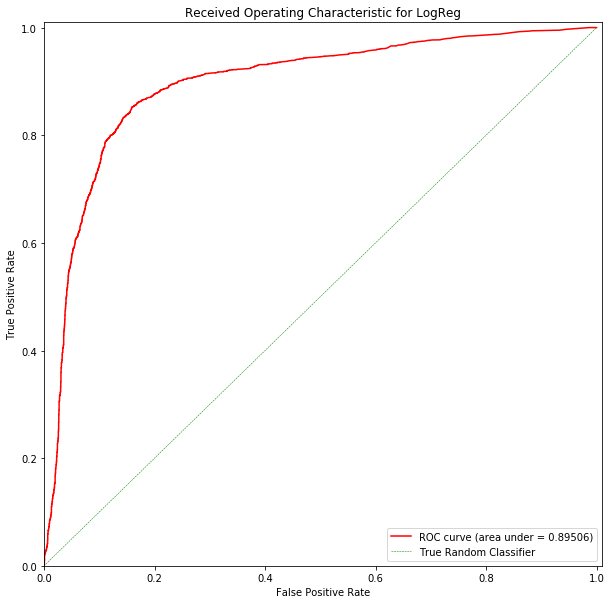

In [8]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

def ROC(target, prob, method):
    FPR, TPR, t = roc_curve(target, prob)
    roc_auc = auc(FPR, TPR)
    print("ROC-AUC:", roc_auc)

    plt.figure(figsize=(10, 10))
    plt.plot(FPR, TPR, color='red', label='ROC curve (area under = %0.5f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='green', lw=0.5, linestyle='--', label='True Random Classifier')
    plt.xlim([0.0, 1.01])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Received Operating Characteristic for %s' % method)
    plt.legend(loc="lower right")
    plt.show()
ROC(Y_test, prob_prediction, "LogReg")

PR-AUC: 0.9028567116745795


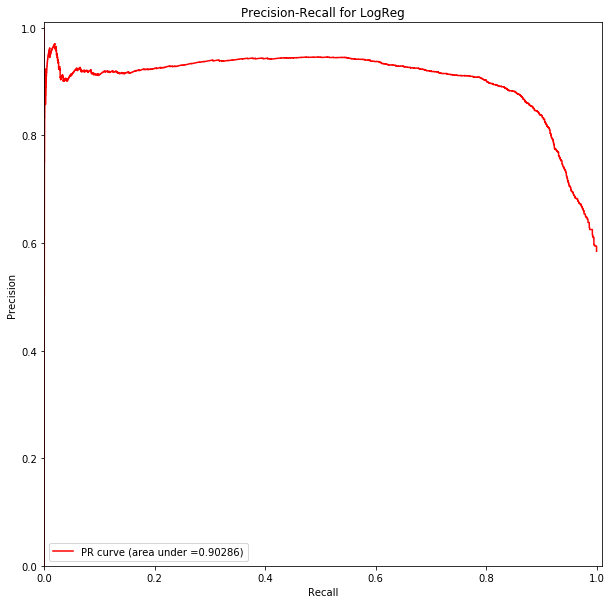

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score
def PR(target, prob, method):
    precision, recall, _ = precision_recall_curve(target, prob)
    pr_auc = average_precision_score(target, prob)
    print("PR-AUC:", pr_auc)

    plt.figure(figsize=(10, 10))
    plt.step(recall, precision, color='red', label='PR curve (area under =%0.5f)' % pr_auc)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.01])
    plt.xlim([0.0, 1.01])
    plt.title('Precision-Recall for %s' % method)
    plt.legend(loc='lower left')
    plt.show()
PR(Y_test, prob_prediction, "LogReg")

# Результаты не самые плохие, но мне кажется, можно и получше.
# Теперь попробуем SVM.

In [10]:
from sklearn.svm import SVC

model = SVC(probability=True)
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
prob_prediction = model.predict_proba(X_test)[:,1]

/home/igor/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 83.87584282724947

TP: 4371   FP: 759 
TN: 2844   FN: 628

Precision: 0.8520467836257309
Recall: 0.874374874974995
F-measure: 0.8630664428867608
ROC-AUC: 0.8940649634228817


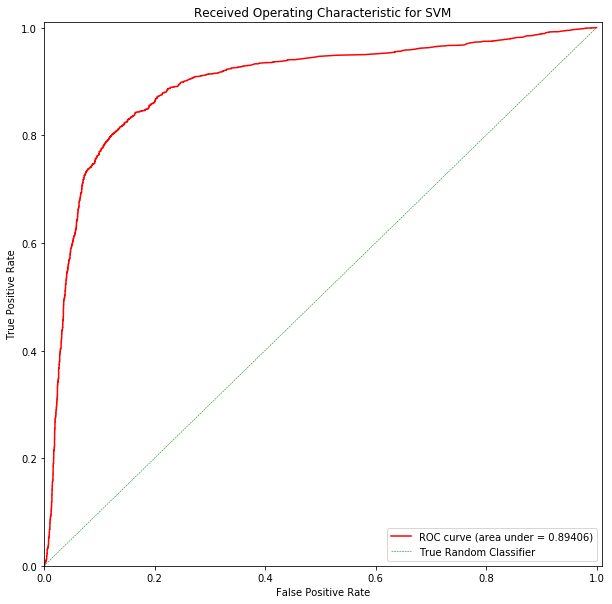

PR-AUC: 0.9028218610750869


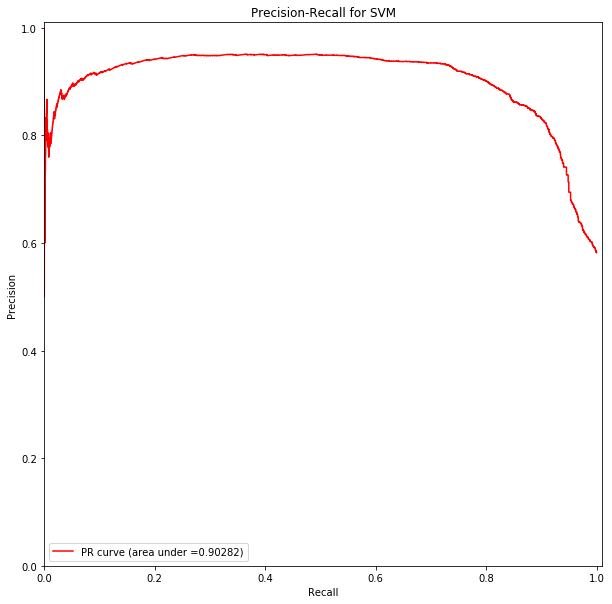

In [11]:
evaluate(prediction, Y_test)
ROC(Y_test, prob_prediction, "SVM")
PR(Y_test, prob_prediction, "SVM")

# Качество подросло аж на 4%, точность увеличилась, а вот полнота немного уменьшилась. ROC-AUC и PR-AUC на том же уровне. Также можно отметить уменьшение количества False Positive объектов.

# Теперь давайте попробуем наивный байесовский классификатор.

In [14]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
prob_prediction = model.predict_proba(X_test)[:,1]

Accuracy: 75.86607765635898

TP: 4650   FP: 1727 
TN: 1876   FN: 349

Precision: 0.729183001411322
Recall: 0.9301860372074415
F-measure: 0.8175105485232067
ROC-AUC: 0.8371842839286703


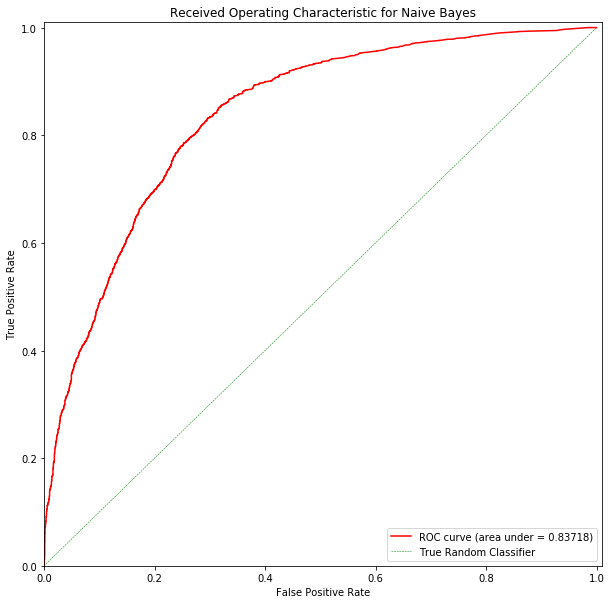

PR-AUC: 0.8630952692702425


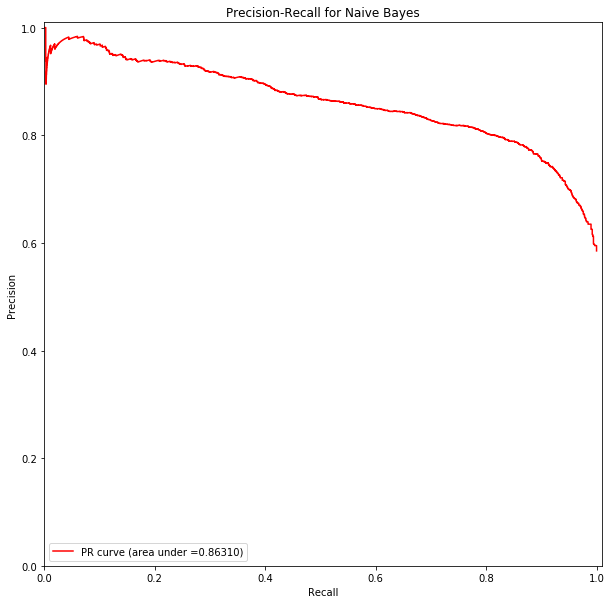

In [15]:
evaluate(prediction, Y_test)
ROC(Y_test, prob_prediction, "Naive Bayes")
PR(Y_test, prob_prediction, "Naive Bayes")

# Кажется, результаты стали хуже - наивный Байес не сработал :(
# Обратимся к методу К-ближайших соседей.

In [18]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=15, weights='distance')
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
prob_prediction = model.predict_proba(X_test)[:,1]

Accuracy: 91.94373401534527

TP: 4555   FP: 249 
TN: 3354   FN: 444

Precision: 0.9481681931723563
Recall: 0.9111822364472895
F-measure: 0.9293073548913597
ROC-AUC: 0.9654982897773006


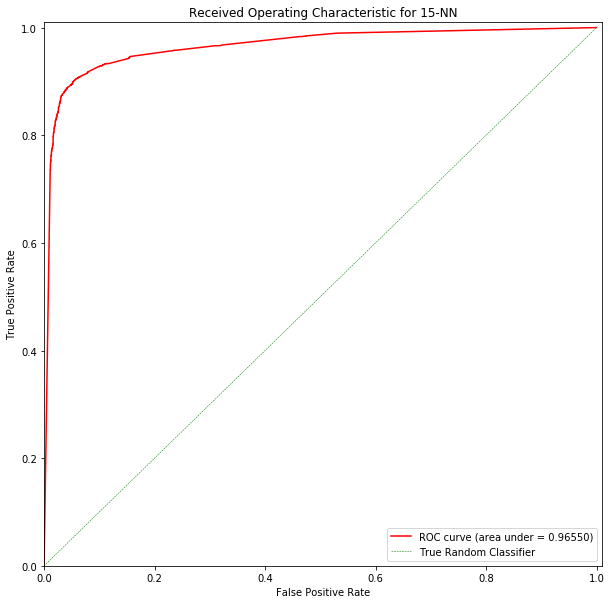

PR-AUC: 0.972060661146311


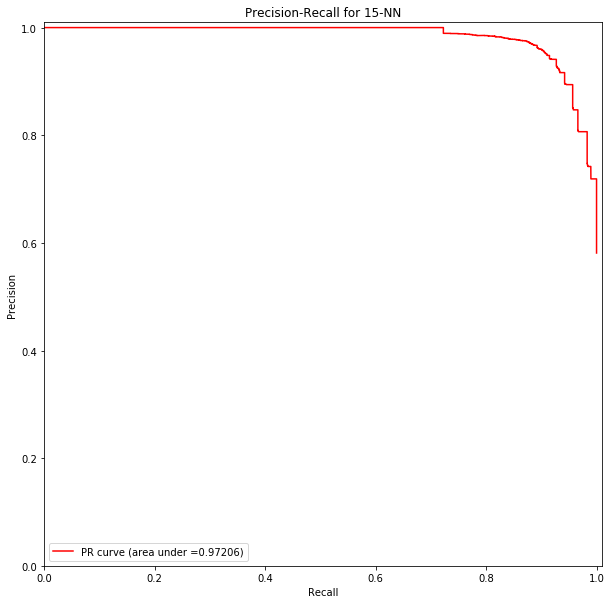

In [19]:
evaluate(prediction, Y_test)
ROC(Y_test, prob_prediction, "15-NN")
PR(Y_test, prob_prediction, "15-NN")

# Впечатляющие результаты! Возможно, я нашел лучший метод для данной задачи?
# Впрочем, это еще не все. Попробуем получить качество получше - для этого я немного поиграюсь с признаками, к примеру, добавлю квадраты и попарные произведения. А еще увеличу количество рассматриваемых соседей до 25.

In [20]:
def expand(features):
    for i in range(5):
        for j in range(i, 5):
            add = features[:,i] * features[:,j]
            add = add.reshape(-1, 1)
            features = np.concatenate((features, add), axis=1)
    return features
X_train = expand(X_train)
X_test = expand(X_test)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(34407, 21) (34407,)
(8602, 21) (8602,)


In [21]:
model = KNeighborsClassifier(n_neighbors=25, weights='distance')
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
prob_prediction = model.predict_proba(X_test)[:,1]

Accuracy: 92.14136247384329

TP: 4574   FP: 251 
TN: 3352   FN: 425

Precision: 0.947979274611399
Recall: 0.9149829965993198
F-measure: 0.9311889250814331
ROC-AUC: 0.9679661716412113


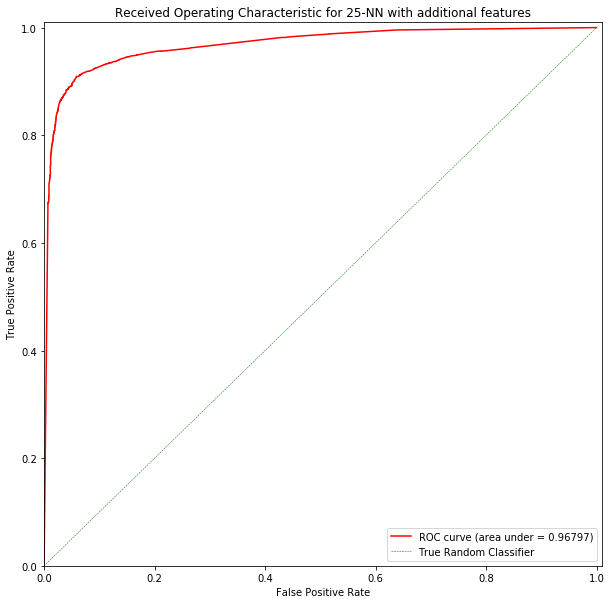

PR-AUC: 0.9752711074548692


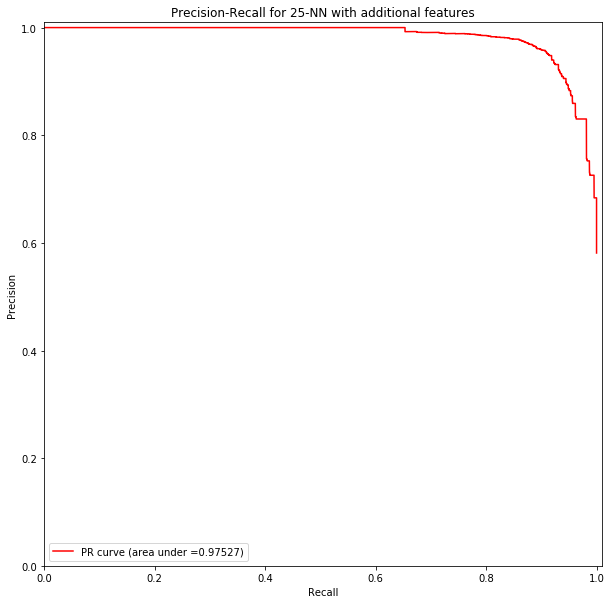

In [22]:
evaluate(prediction, Y_test)
ROC(Y_test, prob_prediction, "25-NN with additional features")
PR(Y_test, prob_prediction, "25-NN with additional features")

# Классификация стала немножечко точнее :)
# Напоследок я оставил классификацию с помощью градиентного бустинга. 

In [25]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(loss='exponential', n_estimators=1000)
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
prob_prediction = model.predict_proba(X_test)[:,1]

Accuracy: 90.13020227853987

TP: 4470   FP: 320 
TN: 3283   FN: 529

Precision: 0.9331941544885177
Recall: 0.8941788357671534
F-measure: 0.9132699969353355
ROC-AUC: 0.9581864471700889


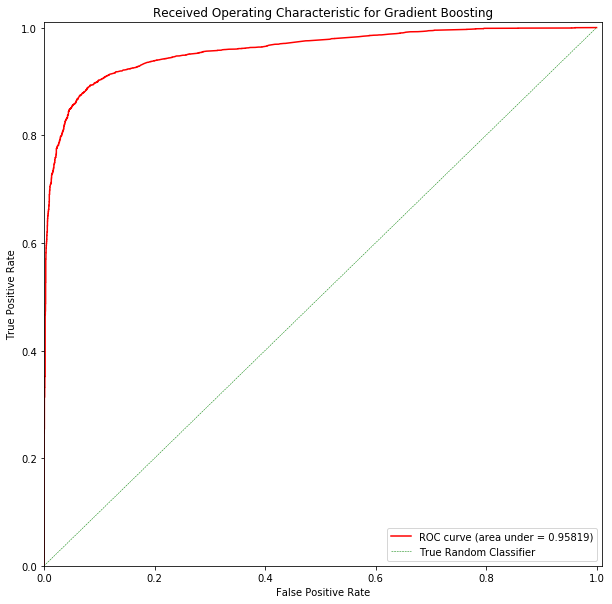

PR-AUC: 0.9730992326400325


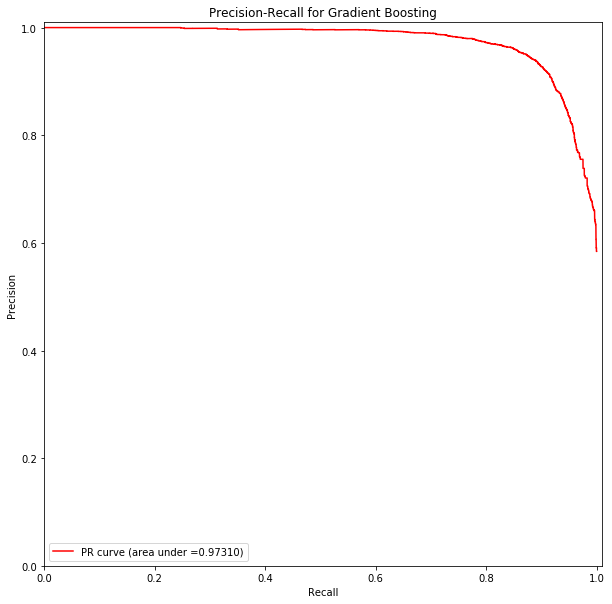

In [26]:
evaluate(prediction, Y_test)
ROC(Y_test, prob_prediction, "Gradient Boosting")
PR(Y_test, prob_prediction, "Gradient Boosting")

# По качеству классификации градиентный бустинг не хуже, чем метод к-ближайших соседей.
# Думаю, на этом можно закончить.